In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/assignment4")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Generating Text with an RNN

In [2]:
! pip install unidecode
import unidecode
import string
import random
import re
import time
import tqdm 
import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [5]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [6]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

on; let me hear
What you profess.

FLORIZEL:
Do, and be witness to 't.

POLIXENES:
And this my neighbour too?

FLORIZEL:
And he, and more
Than he, and men, the earth, the heavens, and all:
That, were I


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [7]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [8]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type="rnn", n_layers=1):
        super(RNN, self).__init__()
        """
        Initialize the RNN model.

        You should create:
        - An Embedding object which will learn a mapping from tensors
        of dimension input_size to embedding of dimension hidden_size.
        - Your RNN network which takes the embedding as input (use models
        in torch.nn). This network should have input size hidden_size and
        output size hidden_size.
        - A linear layer of dimension hidden_size x output_size which
        will predict output scores.

        Inputs:
        - input_size: Dimension of individual element in input sequence to model
        - hidden_size: Hidden layer dimension of RNN model
        - output_size: Dimension of individual element in output sequence from model
        - model_type: RNN network type can be "rnn" (for basic rnn), "gru", or "lstm"
        - n_layers: number of layers in your RNN network
        """

        self.model_type = model_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        ####################################
        #          YOUR CODE HERE          #
        ####################################

        self.input2hidden  = nn.Embedding(input_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)

        if model_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        elif model_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif model_type == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)

        ##########       END      ##########



    def forward(self, input, hidden):
        """
        Forward pass through RNN model. Use your Embedding object to create
        an embedded input to your RNN network. You should then use the
        linear layer to get an output of self.output_size.

        Inputs:
        - input: the input data tensor to your model of dimension (batch_size)
        - hidden: the hidden state tensor of dimension (n_layers x batch_size x hidden_size)

        Returns:
        - output: the output of your linear layer
        - hidden: the output of the RNN network before your linear layer (hidden state)
        """

        output = None

        ####################################
        #          YOUR CODE HERE          #
        ####################################
        batch_size = input.shape[0]
        embedding = self.input2hidden(input).view(1, batch_size, -1)
        # required input size for nn.RNN: seq_len, batch, input_size
        output, hidden = self.rnn(embedding, hidden)
        output = self.hidden2output(output.view(1, batch_size, -1))

        ##########       END      ##########
        return output, hidden

    def init_hidden(self, batch_size, device=None): 
        """
        Initialize hidden states to all 0s during training.

        Hidden states should be initilized to dimension (n_layers x batch_size x hidden_size)

        Inputs:
        - batch_size: batch size

        Returns:
        - hidden: initialized hidden values for input to forward function
        """

        hidden = None

        ####################################
        #          YOUR CODE HERE          #
        ####################################

        if self.model_type == "lstm":
            hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))
        else:
            hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

        ##########       END      ##########

        return hidden

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [10]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [11]:
batch_size = 100
n_epochs = 2500
hidden_size = 150
n_layers = 3
learning_rate = 0.01
model_type = 'lstm'
print_every = 50
plot_every = 50


In [12]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [13]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    batch_size = input.shape[0]
    optimizer.zero_grad()
    hidden = rnn.init_hidden(batch_size, device = device)
    
    for i in range(chunk_len):
        pred, hidden = rnn(input[:, i], hidden)
        loss += criterion(pred.view(batch_size, -1), target[:, i])
    loss /= chunk_len
    loss.backward()
    optimizer.step()
        
    ##########       END      ##########

    return loss 


In [14]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 2500 epochs...
 45s (50 2%) train loss: 2.8409, test_loss: 2.8242]
Wh dare tl h ousrinod,t lal m ns treiser nlhegsrs se


DSRNRCLI:
'on todr c v s,,e;

GSOUAS:
Hor  bers 

 31s (100 4%) train loss: 2.3806, test_loss: 2.3799]
Wher hind pat woce thann der, hroterheas ke lilge then bere witoe,, bheat rosak Cis?

TORELBONDAS:
Tor 

 16s (150 6%) train loss: 2.0864, test_loss: 2.1445]
Whe prishice rettard the,
As
Thure ene me srowpy.

BHALDALUS ODONDANUS:
Anging highe onow be the thaf! 

 2s (200 8%) train loss: 1.9622, test_loss: 1.9877]
Whold dad, thold the spering scerll! theo't
The fregred I aud?

PROSLES:
And the destighar: sell nom d 

 47s (250 10%) train loss: 1.8296, test_loss: 1.9106]
When me your to conse Counk I him they for the word,
Onany, end swear hath be as to rasch.

PANDARUS:
 

 33s (300 12%) train loss: 1.7503, test_loss: 1.8475]
Whis his our her in a man the this.

DUKE QUBET:
All isle of he come with.

DUKE MONTAREY:
Well the po 

 18s (350 14%) train los

In [15]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

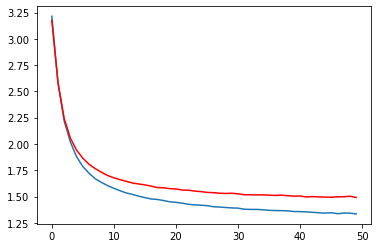

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [17]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The king that she was a bra's beauty in the servants!
What, is my brothers, prepare?

AUTOLYCUS:
Well, which I have took the action: sleep, shall I care
such unmoneyly strike and precice of the
estible, no whein are at my messenger; let him
there is our tongue. No monsterable: I have,
therefore shall come to this spirit to blastine
I repair the cloud, and after that our own.

ORLANDO:
Such, sir, you master and proved the basking: I
can beat the servants:' it were too sword.

PRINCE EDWALD:
O, I think I detest you out of this the dead,
Which shall I have as do you do I
Have dinent to serve our cursely with
here and back of the father sitched then.

COUNTESS:
What is mine a horses at your best brave.

GOWER:
Point, who saw the base day?

OTHELLO:
And part, I think I am glad all the newly to fierce.

RIVERS:
A man be so stood by me; then profess'd with a revolt
Whom what dies for from the baamony,
Even and the like comfort and from what eitherto
Which be see born. How long Page, sweet swe

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.